#### [詳解ディープラーニング　TensorFlow・Kerasによる時系列データ処理](https://book.mynavi.jp/ec/products/detail/id=72995)
　巣籠悠輔 著  
  
support site : [https://book.mynavi.jp/supportsite/detail/9784839962517.html](https://book.mynavi.jp/supportsite/detail/9784839962517.html)  
github : [yusugomori/deeplearning-tensorflow-keras](https://github.com/yusugomori/deeplearning-tensorflow-keras) 


---
## (４章　続き)

### 実装の設計
活性化関数などの変更を容易にする、効率の良いモデル実装について考える。

TensorFlow公式サイトのGet Started - [TensorFlow Mechanics 101](https://www.tensorflow.org/get_started/mnist/mechanics)では、  
グラフを３つの段階に分けて作成する手法を紹介している。

>After creating placeholders for the data, the graph is built from the [mnist.py](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist.py) file according to a 3-stage pattern: inference(), loss(), and training().
- inference() - Builds the graph as far as required for running the network forward to make predictions.
- loss() - Adds to the inference graph the ops required to generate loss.
- training() - Adds to the loss graph the ops required to compute and apply gradients.

また、これに学習部分を加えることでモデルを更に扱いやすくすることができる。  
実装の一例は次の通り。  

In [32]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

# n_hiddens= [n_hidden_1, ..., n_hidden_last]

class DNN(object):
    def __init__(self, n_in, n_hiddens, n_out):
        self.n_hiddens = n_hiddens
        self.n_in = n_in
        self.n_out = n_out
        self.weights = []
        self.biases = []
        
        self._x = None
        self._t = None
        self._keep_prob = None
        self._sess = None
        self._history = {
            'accuracy': [],
            'loss': [],
            'val_loss': [],
            'val_acc': []
        }
    
    def weight_variable(self, shape):
        initial = np.sqrt(2.0 / shape[0]) * tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)
    
    def inference(self, x, keep_prob):
        
        for i, n_hidden in enumerate(self.n_hiddens[:-1]):
            if i==0:
                input_data = x
                input_dim = self.n_in
            else:
                input_data = output
                input_dim = self.n_hiddens[i-1]
            
            self.weights.append(self.weight_variable([input_dim, n_hidden]))
            self.biases.append(self.bias_variable([n_hidden]))
            
            h = tf.nn.relu(tf.matmul(input_data, self.weights[-1]) + self.biases[-1])
            output = tf.nn.dropout(h, keep_prob)
            
        self.weights.append(self.weight_variable([self.n_hiddens[-1], self.n_out]))
        self.biases.append(self.bias_variable([self.n_out]))
        y = tf.nn.softmax(tf.matmul(output, self.weights[-1]) + self.biases[-1])
        return y
                
    def loss(self, y, t, delta=1e-10):
        # model can fit with either definition
        
        #cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y + delta), reduction_indices=[1]))
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(tf.clip_by_value(y, delta, 1.0)), reduction_indices=[1]))
        return cross_entropy
    
    def training(self, loss, optimizer_name='SGD', parameter=[0.01]):
        if optimizer_name == 'Momentum':
            optimizer = tf.train.MomentumOptimizer(parameter[0], parameter[1])
        else:
            optimizer = tf.train.GradientDescentOptimizer(parameter[0])
        train_step = optimizer.minimize(loss)
        return train_step
    
    def accuracy(self, y, t):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
        accuracy_value = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy_value
    
    def fit(self, X_train, Y_train, epochs=1, batch_size=1, p_keep=0.5, verbose=1, optimizer_name='SGD', parameter=[0.01]):
        x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        t = tf.placeholder(tf.float32, shape=[None, self.n_out])
        keep_prob = tf.placeholder(tf.float32)
        self._x = x
        self._t = t
        self._keep_prob = keep_prob
        
        y = self.inference(x, keep_prob)
        loss = self.loss(y, t)
        train_step = self.training(loss, optimizer_name, parameter)
        self.accuracy_value = self.accuracy(y,t)
        
        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)
        self._sess = sess
        
        N_train = len(X_train)
        n_batches = N_train // batch_size
        
        for epoch in range(epochs):
            X_, Y_ = shuffle(X_train, Y_train)
            
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
                
                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    keep_prob: p_keep
                })
                
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                keep_prob: 1.0
            })
            val_acc = self.accuracy_value.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                keep_prob: 1.0
            })
            self._history['val_loss'].append(val_loss)
            self._history['val_acc'].append(val_acc)
        
            
            loss_ = loss.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            accuracy_ = self.accuracy_value.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            self._history['loss'].append(loss_)
            self._history['accuracy'].append(accuracy_)

            if verbose:
                print('epoch:{}'.format(epoch), '\nloss:{}'.format(loss_), '\naccuracy:{}'.format(accuracy_))
            
        return self._history
            
    def evaluate(self, X_test, Y_test):
        return self.accuracy_value.eval(session=self._sess, feed_dict={
            self._x: X_test,
            self._t: Y_test,
            self._keep_prob: 1.0
        })
            
        
        
        

In [34]:
# MNIST dataset
#  for hold-out validation

import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def set_mnist_dataset(data_size=10000, train_size=0.6, validation_size=0.2, test_size=0.2, onehot=True):
        mnist = fetch_mldata('MNIST original', data_home="./dataset")
        indices = np.random.permutation(len(mnist.data))[:data_size]
        X = mnist.data[indices]
        Y = mnist.target[indices]
        
        if onehot:
            Y = np.eye(10)[Y.astype(int)]
        X_train, X_test, Y_train, Y_test = \
            train_test_split(X, Y, train_size=train_size, test_size=test_size)
            
        if validation_size != 0:
            X_train, X_validation, Y_train, Y_validation = \
                train_test_split(X_train, Y_train, 
                                 train_size=round(train_size/(train_size+validation_size), 2), 
                                 test_size=1.-round(train_size/(train_size+validation_size), 2))
            return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
        else:
            return X_train, X_test, Y_train, Y_test

accuracy : 0.9455000162124634


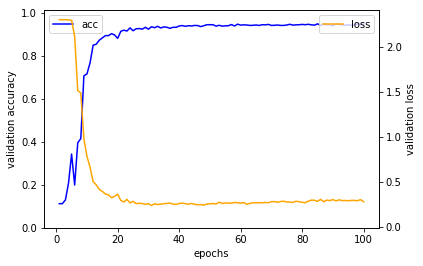

In [35]:
# usage example

import matplotlib.pyplot as plt

# for examination with same seed as in the book
#np.random.seed(0)
#tf.set_random_seed(1234)


# model definition
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = \
    set_mnist_dataset(data_size=10000,  train_size=0.6, validation_size=0.2, test_size=0.2)
n_in, n_out = X_train[0].shape[0], Y_train[0].shape[0]

n_hidden = [200, 200, 200]
model = DNN(n_in, n_hidden, n_out)


# fit
history = model.fit(X_train, Y_train, epochs=100, batch_size=200, p_keep=0.5, 
          verbose=0, optimizer_name='SGD', parameter=[0.01])

accuracy = model.evaluate(X_test, Y_test)
print('accuracy : {}'.format(accuracy))


# plots
def plots(history, epochs):
    fig, ax1 = plt.subplots()
    ax1.plot(np.array(range(epochs))+1, history['val_acc'], label='acc', color='blue')
    ax2 = ax1.twinx()
    ax2.plot(np.array(range(epochs))+1, history['val_loss'], label='loss', color='orange')
    ax1.set_ylim(0,1.01)
    ax2.set_ylim(-0.01,None)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('validation accuracy')
    ax2.set_ylabel('validation loss')
    ax1.legend()
    ax2.legend()
    plt.show()
    
plots(history, epochs=100)